# IEEE_CIS Fraud Detection Kaggle Competition

## Background

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

**Categorical Features - Transaction**
ProductCD
card1 - card6
addr1, addr2
P_emaildomain
R_emaildomain
M1 - M9

**Categorical Features - Identity**
DeviceType
DeviceInfo
id_12 - id_38
The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

**Files**
train_{transaction, identity}.csv - the training set
test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
sample_submission.csv - a sample submission file in the correct format

# Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import preprocessing

# Load Data

In [2]:
# Transaction CSVs
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')

# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

# Sample Submissions
ss = pd.read_csv('sample_submission.csv')

print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


## Join transaction and identity data

In [3]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [4]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [5]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


# Data Processing

## Drop columns with >85% missing values

In [6]:
perc_thresh = .85
thresh_train = len(train) * perc_thresh
train.dropna(thresh = thresh_train, axis = 'columns', inplace = True)

print('train shape is {}'.format(train.shape))

train shape is (590540, 160)


In [7]:
cols_to_keep = [x for x in train.columns if x != 'isFraud']
test = test[cols_to_keep]
print('test shape is {}'.format(test.shape))

test shape is (506691, 159)


## Fill N/A with previous value

In [8]:
train = train.fillna(-999)
test = test.fillna(-999)

## Prepare data for validation / modeling

In [9]:
X = train.drop('isFraud',axis='columns')
X.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,86400,68.5,W,13926,-999.0,150.0,discover,142.0,credit,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
y = train['isFraud']

## Encode categorical variables

In [11]:
for f in X.columns:
    if X[f].dtype=='object' or test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[f].values) + list(test[f].values))
        X[f] = lbl.transform(list(X[f].values))
        test[f] = lbl.transform(list(test[f].values))

# Find Optimal Hyperparameters

## Split dataset into training set and validation set

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

## Build Models

### AdaBoost Classifier

In [13]:
ABC = AdaBoostClassifier(
    n_estimators=500,
    learning_rate=1)
ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=500, random_state=None)

In [14]:
y_val_pred = ABC.predict(X_val)
y_val_pred_proba = ABC.predict_proba(X_val)

### ROC Curve

In [15]:
# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_val, y_val_pred_proba[:,1])

# Print roc_auc_score
print('ROC AUC score: {:.4f}'.format(ada_roc_auc))

ROC AUC score: 0.8847


In [16]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba[:,1])

In [17]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, "b:", label=label, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.title('ROC Curve')
    plt.legend()

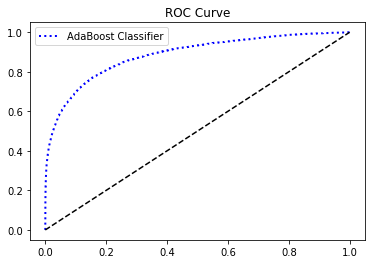

In [18]:
plot_roc_curve(fpr, tpr, label='AdaBoost Classifier')
plt.show()

### Hyperparameter Tuning

In [ ]:
param_grid = {
 'n_estimators': [500,750],
 'learning_rate' : [1,5],
 }

ABC = AdaBoostClassifier()

grid_search = GridSearchCV(ABC, param_grid, 
                           cv=3, scoring='roc_auc',
                           n_jobs = -1, verbose=True)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

### Best Model Thus Far

{'learning_rate': 1, 'n_estimators': 750}

### Train and Fit

In [20]:
ABC = AdaBoostClassifier(
    n_estimators=500,
    learning_rate=1)
ABC.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=500, random_state=None)

In [21]:
y_test_pred = ABC.predict(test)
y_test_pred_proba = ABC.predict_proba(test)

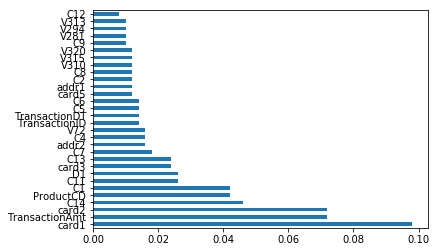

In [30]:
(pd.Series(ABC.feature_importances_, index=X.columns)
   .nlargest(30)
   .plot(kind='barh'))

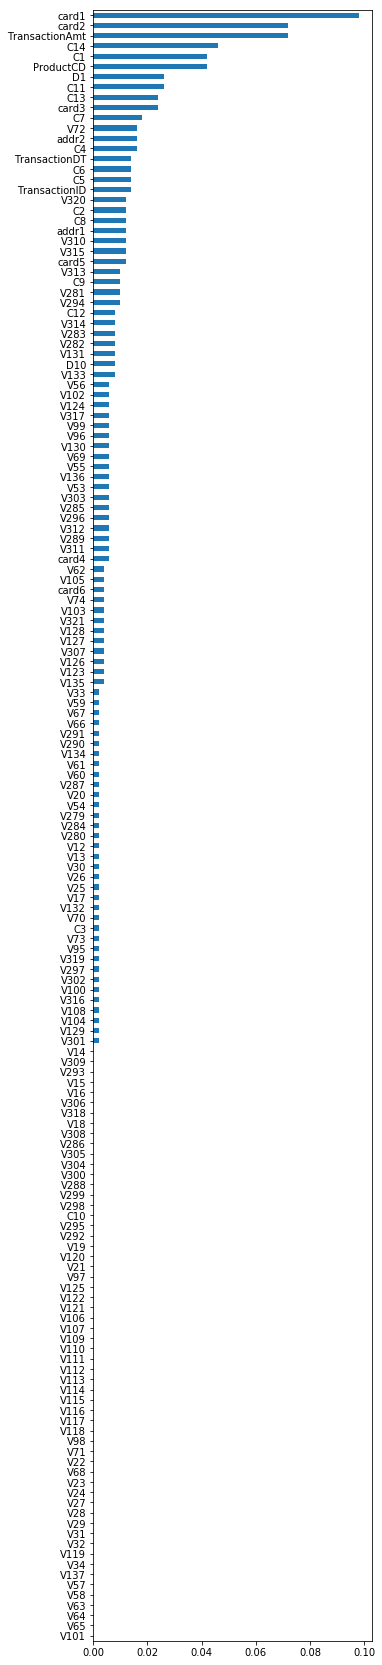

In [41]:
importances = pd.Series(ABC.feature_importances_, index = X.columns).sort_values()
importances.plot(kind = 'barh',figsize=[5,30])

# Write Output

In [27]:
ss['isFraud'] = y_test_pred_proba[:,1]
ss.to_csv('AdaBoost Model.csv',index=False)